In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from utils.model_utils import ResidualAttentionNetwork
from utils.model_utils import AttentionActivationType, AttentionModule, LearningOutput
from matplotlib import pyplot as plt
import pickle

%load_ext autoreload
%autoreload 2

In [2]:
cifar10_dataset = tf.keras.datasets.cifar10

(X_train, y_train), (X_test, y_test) = cifar10_dataset.load_data()
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Validation data shape: ', X_test.shape)
print('Validation labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000, 10)
Validation data shape:  (10000, 32, 32, 3)
Validation labels shape:  (10000, 10)


In [3]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# For CIFAR 10 dataset, the mean and standard deviation
# values for every channel:
mean = [125.3, 123.0, 113.9]
std = [63.0, 62.1, 66.7]

# X - mean / std
for i in range(3):
    X_train[:,:,:,i] = (X_train[:,:,:,i] - mean[i]) / std[i]
    X_test[:,:,:,i] = (X_test[:,:,:,i] - mean[i]) / std[i]
    
# Using data augmentation
datagen = ImageDataGenerator(horizontal_flip=True,
                             width_shift_range=0.15,
                             height_shift_range=0.15,
                             validation_split=0.2)

datagen.fit(X_train)

input_shape = X_train.shape[1:]
output_size = 10

In [4]:
# Learning rate scheduler
def learning_rate_scheduler(epoch, lr):
    if epoch == 65:
        return lr * 0.1
    if epoch == 120:
        return lr * 0.1
    if epoch == 180:
        return lr * 0.1
    else:
        return lr

In [5]:
"""
Dataset: Cifar10
Model: Attention-92
Optimizer: SGD
Batch size = 64
epochs = 250
ATTENTION_RESIDUAL learning, spatial attention activation used here
"""
residual_attention_network = ResidualAttentionNetwork(input_shape=input_shape,
                                                      output_size=output_size,
                                                      attention_model=AttentionModule.ATTENTION92,
                                                     attention_activation_type=AttentionActivationType.SPATIAL_ATTENTION)
model = residual_attention_network.attention_mod()

model.compile(tf.keras.optimizers.SGD(lr=0.1, decay=0.0001, momentum=0.9, nesterov=True),
              loss=tf.keras.losses.CategoricalCrossentropy(), 
              metrics=['accuracy'])

callback_accuracy = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=15)
callback_lr = tf.keras.callbacks.LearningRateScheduler(learning_rate_scheduler)

In [6]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   4864        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 16, 16, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 16, 64)   256         max_pooling2d[0][0]              
______________________________________________________________________________________________

In [7]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=64, subset='training'), validation_data=datagen.flow(X_train, y_train, batch_size=64, subset='validation'),
                    epochs=250, callbacks=[callback_accuracy,callback_lr])

Epoch 1/250
625/625 [==============================] - 84s 110ms/step - loss: 2.3895 - accuracy: 0.1688 - val_loss: 2.0155 - val_accuracy: 0.2017
Epoch 2/250
625/625 [==============================] - 67s 107ms/step - loss: 1.8958 - accuracy: 0.2679 - val_loss: 1.8453 - val_accuracy: 0.2755
Epoch 3/250
625/625 [==============================] - 66s 106ms/step - loss: 1.7900 - accuracy: 0.3017 - val_loss: 2.0440 - val_accuracy: 0.2443
Epoch 4/250
625/625 [==============================] - 67s 107ms/step - loss: 1.7049 - accuracy: 0.3330 - val_loss: 1.6628 - val_accuracy: 0.3561
Epoch 5/250
625/625 [==============================] - 66s 106ms/step - loss: 1.6275 - accuracy: 0.3621 - val_loss: 1.5770 - val_accuracy: 0.3874
Epoch 6/250
625/625 [==============================] - 66s 106ms/step - loss: 1.5831 - accuracy: 0.3835 - val_loss: 1.6250 - val_accuracy: 0.3671
Epoch 7/250
625/625 [==============================] - 66s 106ms/step - loss: 1.5368 - accuracy: 0.3991 - val_loss: 1.4729 -

Epoch 58/250
458/625 [====================>.........] - ETA: 15s - loss: 0.7295 - accuracy: 0.7418

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



625/625 [==============================] - 64s 103ms/step - loss: 0.7073 - accuracy: 0.7518 - val_loss: 0.8345 - val_accuracy: 0.7201
Epoch 62/250
625/625 [==============================] - 65s 103ms/step - loss: 0.7186 - accuracy: 0.7509 - val_loss: 0.8335 - val_accuracy: 0.7159
Epoch 63/250
625/625 [==============================] - 67s 107ms/step - loss: 0.7098 - accuracy: 0.7529 - val_loss: 0.8171 - val_accuracy: 0.7247
Epoch 64/250
625/625 [==============================] - 65s 103ms/step - loss: 0.7132 - accuracy: 0.7496 - val_loss: 0.7734 - val_accuracy: 0.7313
Epoch 65/250
625/625 [==============================] - 65s 103ms/step - loss: 0.6905 - accuracy: 0.7614 - val_loss: 0.7953 - val_accuracy: 0.7243
Epoch 66/250
625/625 [==============================] - 65s 103ms/step - loss: 0.6723 - accuracy: 0.7678 - val_loss: 0.6672 - val_accuracy: 0.7676
Epoch 67/250
625/625 [==============================] - 65s 103ms/step - loss: 0.6221 - accuracy: 0.7802 - val_loss: 0.6741 - val_a

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



625/625 [==============================] - 65s 104ms/step - loss: 0.5745 - accuracy: 0.7984 - val_loss: 0.6469 - val_accuracy: 0.7785
Epoch 108/250
625/625 [==============================] - 65s 104ms/step - loss: 0.5791 - accuracy: 0.8011 - val_loss: 0.6498 - val_accuracy: 0.7768
Epoch 109/250
625/625 [==============================] - 65s 104ms/step - loss: 0.5773 - accuracy: 0.7985 - val_loss: 0.6371 - val_accuracy: 0.7804
Epoch 110/250
625/625 [==============================] - 65s 103ms/step - loss: 0.5779 - accuracy: 0.7973 - val_loss: 0.6452 - val_accuracy: 0.7779
Epoch 111/250
625/625 [==============================] - 65s 104ms/step - loss: 0.5776 - accuracy: 0.8019 - val_loss: 0.6419 - val_accuracy: 0.7758
Epoch 112/250
290/625 [============>.................] - ETA: 31s - loss: 0.5826 - accuracy: 0.7971

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



625/625 [==============================] - 65s 104ms/step - loss: 0.5573 - accuracy: 0.8050 - val_loss: 0.6271 - val_accuracy: 0.7866
Epoch 125/250
625/625 [==============================] - 65s 104ms/step - loss: 0.5695 - accuracy: 0.8013 - val_loss: 0.6223 - val_accuracy: 0.7833
Epoch 126/250
625/625 [==============================] - 65s 104ms/step - loss: 0.5605 - accuracy: 0.8041 - val_loss: 0.6352 - val_accuracy: 0.7789
Epoch 127/250
625/625 [==============================] - 65s 104ms/step - loss: 0.5695 - accuracy: 0.8025 - val_loss: 0.6340 - val_accuracy: 0.7803
Epoch 128/250
625/625 [==============================] - 65s 104ms/step - loss: 0.5602 - accuracy: 0.8073 - val_loss: 0.6344 - val_accuracy: 0.7818
Epoch 129/250
409/625 [==================>...........] - ETA: 20s - loss: 0.5537 - accuracy: 0.8063

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [8]:
# Evaluate model
model.evaluate(X_test, y_test)

313/313 [==============================] - 10s 22ms/step - loss: 0.6249 - accuracy: 0.7874


[0.6248746514320374, 0.7874000072479248]

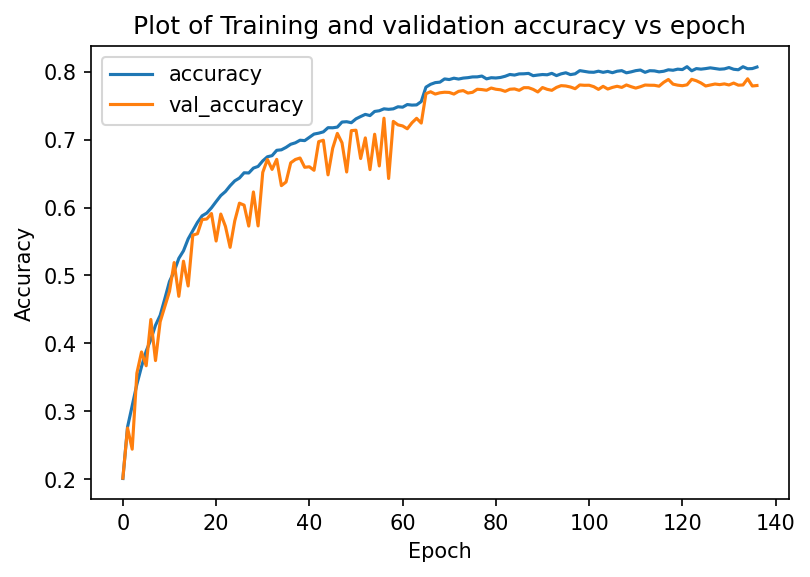

In [9]:
#Plot accuracy
fig = plt.figure(figsize=(6, 4), dpi=150)
plt.title("Plot of Training and validation accuracy vs epoch")
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.savefig('Cifar10_Attn92_accplot.png')
plt.legend(loc='upper left')
plt.show()

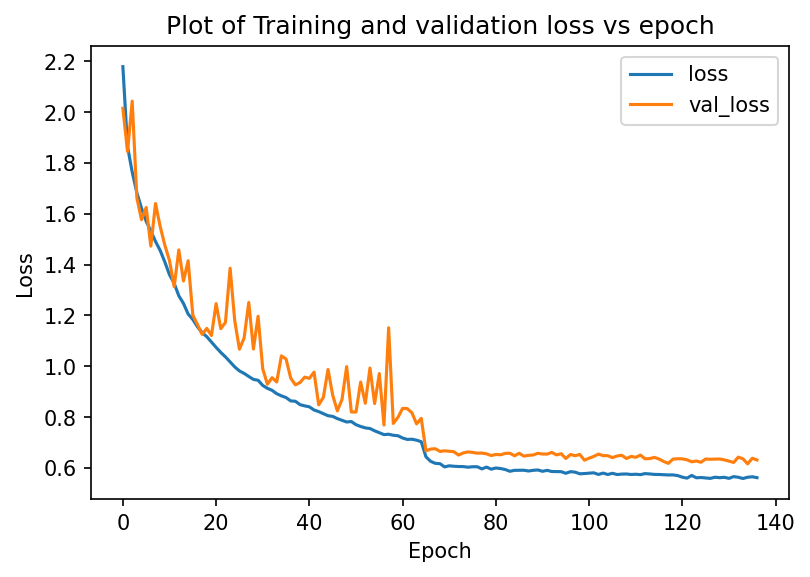

In [10]:
#Plot loss
fig = plt.figure(figsize=(6, 4), dpi=150)
plt.title("Plot of Training and validation loss vs epoch")
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig('Cifar10_Attn92_lossplot.png')
plt.legend(loc='upper right')
plt.show()

In [11]:
# cifar<10or100>_attn<56or92>_<lrn-mech>_<attn-act-type>
model.save(filepath = "./model/cifar10_attn92_arl_spatial")

INFO:tensorflow:Assets written to: ./model/cifar10_attn92_arl_spatial/assets
